## Quora Insincere Question Classification

### Abstract 

The objective is to predict whether a question asked on Quora is sincere or not.
An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
- Has an exaggerated tone to underscore a point about a group of people
- Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
- Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
- Makes disparaging attacks/insults against a specific person or group of people

### Part A - Deep Learning model

I will try various Deep Learning Algorithms to see which works best of this dataset like LSTM, Conv1D, GRU etc. I will also use pre-trained word embeddings in few algorithms. As a baseline, I will use Logistic regression.

Deep Learning Models - 

- LSTM
- GRU 
- Conv1D
- Bidirectional GRU
- Pretrained Embeddings (Wiki Fast Text)
- Bidirectional LSTM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time, gc, warnings

import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GRU, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras import initializers, regularizers, constraints, optimizers, layers

from wordcloud import WordCloud, STOPWORDS

np.random.seed(42)
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

%matplotlib inline

In [3]:
os.chdir(r'N:\ADVANCE DATA SCIENCE\ASSIGNMENTS\Assignment 3')

In [4]:
df_Quora = pd.read_csv('quora_questions_.csv')

In [5]:
df_Quora.shape

(93590, 3)

In [6]:
df_Quora[df_Quora.target == 0].head(5)

,qid,question_text,target
0,69d762db89f677e2b38d,How can I live fully happier life?,0
1,de052885a7cb6483c482,What is the difference between IT and computer...,0
2,5cf30b565aa71a3ce65c,Why a suit is the dress code of business people?,0
3,a2483d6b6debff584f87,How can you get the earnest money loan for a b...,0
4,c93fef8401e553bbee16,Why would an atheist care if others celebrate ...,0


In [7]:
df_Quora[df_Quora.target == 1].head(5)

,qid,question_text,target
61266,9d91dabfc5358b6e9b4a,"Has Trump (since becoming president), ever com...",1
61267,cafdbedf2152a331cf88,Why Turkish people and Iranians look white des...,1
61268,877e654f6097f6dde056,"Do Hungarians envy Romania, because they are b...",1
61269,341b769d29966cae4b16,"I just got a message that my answer had been ""...",1
61270,136b7b3b0dc24a6256c0,What does black man cum taste like?,1


### Data Pre-processing

In [8]:
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [9]:
def clean_text(question):
    """
    This function receives comments and returns clean word-list
    """
    question = question.lower()
    question = re.sub("\\n", "", question)
    question = re.sub("\'", "", question)
    question = re.sub("\W+", " ", question)
    
    #Split the sentences into words
    words = tokenizer.tokenize(question)
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in punctuations]
    #words = [''.join(x for x in w if x.isalpha()) for w in words]

    clean_sen = " ".join(words)
    
    return clean_sen

In [10]:
df_Quora["question_text_"] = df_Quora["question_text"].apply(lambda question: clean_text(question))
df_Quora.head()

,qid,question_text,target,question_text_
0,69d762db89f677e2b38d,How can I live fully happier life?,0,how can i live fully happier life
1,de052885a7cb6483c482,What is the difference between IT and computer...,0,what be the difference between it and computer...
2,5cf30b565aa71a3ce65c,Why a suit is the dress code of business people?,0,why a suit be the dress code of business people
3,a2483d6b6debff584f87,How can you get the earnest money loan for a b...,0,how can you get the earnest money loan for a b...
4,c93fef8401e553bbee16,Why would an atheist care if others celebrate ...,0,why would an atheist care if others celebrate ...


### Feature Extraction

In [11]:
features = df_Quora['question_text_']
target = df_Quora['target']

In [12]:
df_Quora['num_words'] = df_Quora['question_text_'].apply(lambda x: len(str(x).split()))

In [13]:
df_Quora.groupby(['target']).num_words.median()

target
0    11
1    15
Name: num_words, dtype: int64

In [15]:
embed_size = 200     # how big is each word vector
max_features = 30000     # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100       # max number of words in a question to use

In [16]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(features) 
X_features = tokenizer.texts_to_sequences(features)
X_features = pad_sequences(X_features, maxlen=maxlen)

In [17]:
Y = target

### Stratified Split 

To avoid Sampling Bias due to Random Sampling, I will split the data using Stratifed Split as the 2 output classes are imbalanced. 

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.1, stratify=Y, random_state=100)

### LSTM Model

In [67]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embed_size, input_length=maxlen))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model_lstm.add(GlobalMaxPool1D())
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 300)          9000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 300)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 64)           93440     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 9,093,505
Trainable params: 9,093,505
Non-trainable params: 0
_________________________________________________________________


In [68]:
## Train the LSTM model 
history_lstm = model_lstm.fit(X_train, Y_train, batch_size=256, epochs=5, validation_data=(X_test, Y_test))

Train on 84231 samples, validate on 9359 samples
Epoch 1/5
84231/84231 [==============================] - 569s 7ms/step - loss: 0.5858 - acc: 0.6853 - val_loss: 0.4118 - val_acc: 0.8263
Epoch 2/5
84231/84231 [==============================] - 563s 7ms/step - loss: 0.3551 - acc: 0.8532 - val_loss: 0.3150 - val_acc: 0.8691
Epoch 3/5
84231/84231 [==============================] - 603s 7ms/step - loss: 0.2928 - acc: 0.8838 - val_loss: 0.2897 - val_acc: 0.8826
Epoch 4/5
84231/84231 [==============================] - 599s 7ms/step - loss: 0.2658 - acc: 0.8963 - val_loss: 0.2802 - val_acc: 0.8875
Epoch 5/5
84231/84231 [==============================] - 650s 8ms/step - loss: 0.2485 - acc: 0.9050 - val_loss: 0.2759 - val_acc: 0.8902


9359/9359 [==============================] - 26s 3ms/step
Test Loss:  0.2759420616477202
Test Accuracy 0.8901592050432738
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


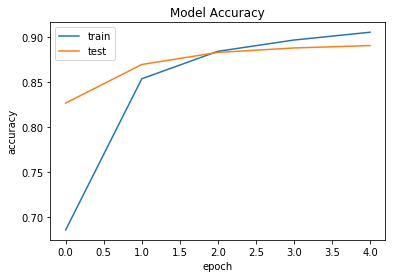

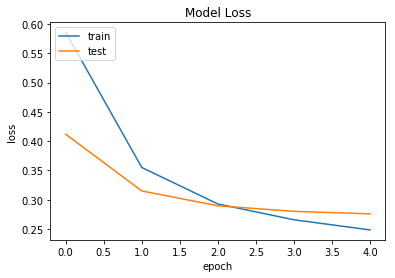

In [69]:
import matplotlib.pyplot as plt
#print(metrics.accuracy_score(Y_test, Y_predicted))

score = model_lstm.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['acc'])
plt.plot(history_lstm.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
Y_pred = model_lstm.predict([X_test], batch_size=256, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

9359/9359 [==============================] - 15s 2ms/step
F1 score at threshold 0.1 is 0.7956072351421187
F1 score at threshold 0.12 is 0.8066825775656324
F1 score at threshold 0.14 is 0.8152849041317849
F1 score at threshold 0.16 is 0.8223197148341103
F1 score at threshold 0.18 is 0.8260748959778085
F1 score at threshold 0.2 is 0.8316025820937413
F1 score at threshold 0.22 is 0.8342776203966007
F1 score at threshold 0.24 is 0.8363844393592679
F1 score at threshold 0.26 is 0.838141950375072
F1 score at threshold 0.28 is 0.8414776032577079
F1 score at threshold 0.3 is 0.8445421245421245
F1 score at threshold 0.32 is 0.8457227138643068
F1 score at threshold 0.34 is 0.8448403860430587
F1 score at threshold 0.36 is 0.8445108289768485
F1 score at threshold 0.38 is 0.8452864230942716
F1 score at threshold 0.4 is 0.8455826640400059
F1 score at threshold 0.42 is 0.8437118437118437
F1 score at threshold 0.44 is 0.8431402673221693
F1 score at threshold 0.46 is 0.8409161250386877
F1 score at thre

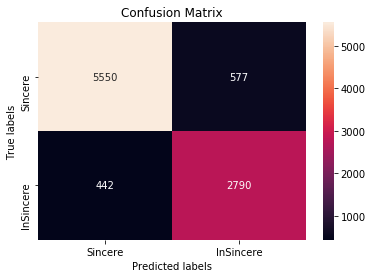

In [71]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.4).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Conv1D Model

In [22]:
filters = 64
kernel_size = 3
hidden_dims = 64

model_conv = Sequential()

model_conv.add(Embedding(max_features, 
                         embed_size,
                         input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model_conv.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model_conv.add(Dense(hidden_dims, activation='relu'))
model_conv.add(Dropout(0.2))
model_conv.add(Dense(1, activation='sigmoid'))

model_conv.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 64)            38464     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total para

In [23]:
## Train the LSTM model 
history_conv = model_conv.fit(X_train, Y_train, batch_size=256, epochs=1, validation_data=(X_test, Y_test))

Train on 84231 samples, validate on 9359 samples
Epoch 1/1
84231/84231 [==============================] - 2482s 29ms/step - loss: 0.3562 - acc: 0.8418 - val_loss: 0.2763 - val_acc: 0.8876


In [46]:
Y_pred = model_conv.predict([X_test], batch_size=256, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

9359/9359 [==============================] - 2s 250us/step
F1 score at threshold 0.1 is 0.7754695857693743
F1 score at threshold 0.12 is 0.7896744659206512
F1 score at threshold 0.14 is 0.7981900452488688
F1 score at threshold 0.16 is 0.8063542076933176
F1 score at threshold 0.18 is 0.8120340788072418
F1 score at threshold 0.2 is 0.8188190887031546
F1 score at threshold 0.22 is 0.8227917121046893
F1 score at threshold 0.24 is 0.8255894112780918
F1 score at threshold 0.26 is 0.8279225303051415
F1 score at threshold 0.28 is 0.8296587557927256
F1 score at threshold 0.3 is 0.8333569706424621
F1 score at threshold 0.32 is 0.8349514563106796
F1 score at threshold 0.34 is 0.8373364015532864
F1 score at threshold 0.36 is 0.8391588107324147
F1 score at threshold 0.38 is 0.8400933761307265
F1 score at threshold 0.4 is 0.8396767083027186
F1 score at threshold 0.42 is 0.8415284360189573
F1 score at threshold 0.44 is 0.8405365126676604
F1 score at threshold 0.46 is 0.8410010490034466
F1 score at th

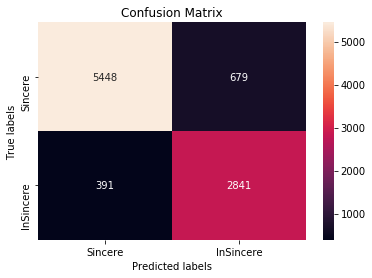

In [47]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.42).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Bidirectional GRU

In [20]:
from keras.callbacks import ReduceLROnPlateau
hidden_dims = 16

model_gru = Sequential()

model_gru.add(Embedding(max_features, 
                         embed_size,
                         input_length=maxlen))
#model_gru.add(Dropout(0.2))
model_gru.add(Bidirectional(GRU(64, return_sequences=True)))
model_gru.add(GlobalMaxPooling1D())
model_gru.add(Dense(hidden_dims, activation='relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_gru.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,103,841
Trainable params: 6,103,841
Non-trainable params: 0
_________________________________________________________________


In [21]:
## Train the LSTM model 
history_gru = model_gru.fit(X_train, Y_train, batch_size=256, epochs=5, validation_data=(X_test, Y_test), callbacks=[rlrop])

Train on 84231 samples, validate on 9359 samples
Epoch 1/5
84231/84231 [==============================] - 344s 4ms/step - loss: 0.3490 - acc: 0.8485 - val_loss: 0.2686 - val_acc: 0.8898
Epoch 2/5
84231/84231 [==============================] - 344s 4ms/step - loss: 0.2408 - acc: 0.9098 - val_loss: 0.2694 - val_acc: 0.8912
Epoch 3/5
84231/84231 [==============================] - 341s 4ms/step - loss: 0.1870 - acc: 0.9342 - val_loss: 0.2851 - val_acc: 0.8894
Epoch 4/5
84231/84231 [==============================] - 343s 4ms/step - loss: 0.1772 - acc: 0.9394 - val_loss: 0.2865 - val_acc: 0.8890
Epoch 5/5
84231/84231 [==============================] - 368s 4ms/step - loss: 0.1758 - acc: 0.9399 - val_loss: 0.2867 - val_acc: 0.8890


9359/9359 [==============================] - 12s 1ms/step
Test Loss:  0.28670144012493004
Test Accuracy 0.888983865797628
dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


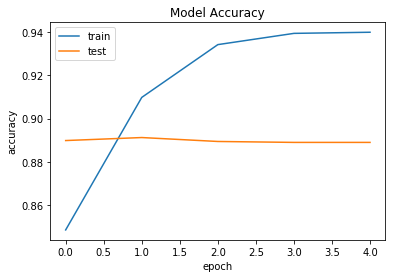

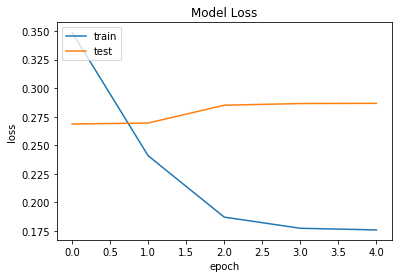

In [22]:
import matplotlib.pyplot as plt
#print(metrics.accuracy_score(Y_test, Y_predicted))

score = model_gru.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_gru.history.keys())
# summarize history for accuracy
plt.plot(history_gru.history['acc'])
plt.plot(history_gru.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
Y_pred = model_gru.predict([X_test], batch_size=256, verbose=1)
for thresh in np.arange(0.1, 0.601, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

9359/9359 [==============================] - 15s 2ms/step
F1 score at threshold 0.1 is 0.8026899798251512
F1 score at threshold 0.12 is 0.8079542359030236
F1 score at threshold 0.14 is 0.8122763556289568
F1 score at threshold 0.16 is 0.8161335187760779
F1 score at threshold 0.18 is 0.8185382245869505
F1 score at threshold 0.2 is 0.8187843745593005
F1 score at threshold 0.22 is 0.8186469584991471
F1 score at threshold 0.24 is 0.8207182715696093
F1 score at threshold 0.26 is 0.8217165898617511
F1 score at threshold 0.28 is 0.8210770121598147
F1 score at threshold 0.3 is 0.8205873800523408
F1 score at threshold 0.32 is 0.8208497590889181
F1 score at threshold 0.34 is 0.8226138032305433
F1 score at threshold 0.36 is 0.8239988177922268
F1 score at threshold 0.38 is 0.8235468564650059
F1 score at threshold 0.4 is 0.8245979749851102
F1 score at threshold 0.42 is 0.8252166118912458
F1 score at threshold 0.44 is 0.8252631578947368
F1 score at threshold 0.46 is 0.8246302444913975
F1 score at thr

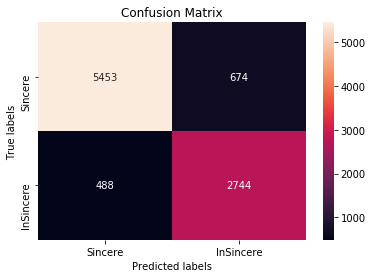

In [49]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.44).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Wiki News FastText Embeddings

Now let us use the FastText embeddings trained on Wiki News corpus

In [23]:
EMBEDDING_FILE = 'wiki-news-300d-1M.vec'

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) 
                        for o in open(EMBEDDING_FILE, encoding="utf-8") if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

In [25]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model_Wiki = Model(inputs=inp, outputs=x)
model_Wiki.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

model_Wiki.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          9000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total para

In [26]:
## Train the LSTM model 
history_wiki = model_Wiki.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_test, Y_test))

Train on 84231 samples, validate on 9359 samples
Epoch 1/5
84231/84231 [==============================] - 661s 8ms/step - loss: 0.6352 - acc: 0.6550 - val_loss: 0.6062 - val_acc: 0.6547
Epoch 2/5
84231/84231 [==============================] - 651s 8ms/step - loss: 0.5811 - acc: 0.6781 - val_loss: 0.5485 - val_acc: 0.7009
Epoch 3/5
84231/84231 [==============================] - 634s 8ms/step - loss: 0.5132 - acc: 0.7692 - val_loss: 0.4716 - val_acc: 0.8049
Epoch 4/5
84231/84231 [==============================] - 609s 7ms/step - loss: 0.4384 - acc: 0.8271 - val_loss: 0.3977 - val_acc: 0.8459
Epoch 5/5
84231/84231 [==============================] - 611s 7ms/step - loss: 0.3743 - acc: 0.8514 - val_loss: 0.3460 - val_acc: 0.8577


9359/9359 [==============================] - 14s 1ms/step
Test Loss:  0.34595609111037695
Test Accuracy 0.8576771022545143
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


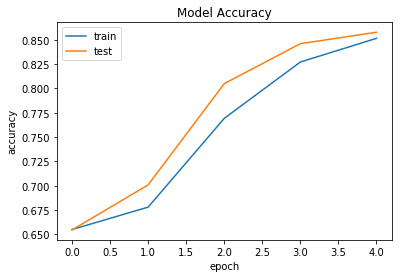

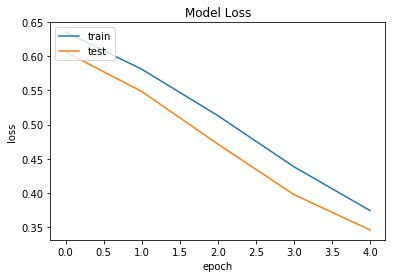

In [27]:
import matplotlib.pyplot as plt
#print(metrics.accuracy_score(Y_test, Y_predicted))

score = model_Wiki.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_wiki.history.keys())
# summarize history for accuracy
plt.plot(history_wiki.history['acc'])
plt.plot(history_wiki.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_wiki.history['loss'])
plt.plot(history_wiki.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
Y_pred = model_Wiki.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

9359/9359 [==============================] - 12s 1ms/step
F1 score at threshold 0.1 is 0.6660367454068242
F1 score at threshold 0.12 is 0.6942366915970084
F1 score at threshold 0.14 is 0.716111364673665
F1 score at threshold 0.16 is 0.7324540744229864
F1 score at threshold 0.18 is 0.7484826414178198
F1 score at threshold 0.2 is 0.7581308411214954
F1 score at threshold 0.22 is 0.7695652173913043
F1 score at threshold 0.24 is 0.7777196652719665
F1 score at threshold 0.26 is 0.7843241802186083
F1 score at threshold 0.28 is 0.7916270218839201
F1 score at threshold 0.3 is 0.794562352614787
F1 score at threshold 0.32 is 0.7985316956092052
F1 score at threshold 0.34 is 0.800975749748888
F1 score at threshold 0.36 is 0.7994730679156908
F1 score at threshold 0.38 is 0.8011262596324836
F1 score at threshold 0.4 is 0.8019294543261983
F1 score at threshold 0.42 is 0.7988955361251726
F1 score at threshold 0.44 is 0.7960680293337493
F1 score at threshold 0.46 is 0.7933596837944664
F1 score at thresh

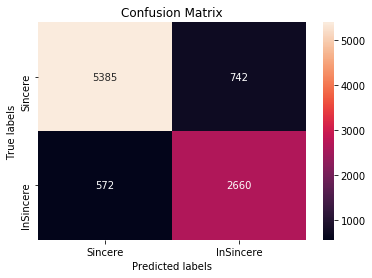

In [29]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.4).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Wiki News with Bidirectional LSTM

In [83]:
model_Wiki_L = Sequential()
model_Wiki_L.add(Embedding(max_features, embed_size, input_length=maxlen, weights=[embedding_matrix]))
#model_Wiki_L.add(SpatialDropout1D(0.2))
model_Wiki_L.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
#model_Wiki_L.add(BatchNormalization())
model_Wiki_L.add(GlobalMaxPool1D())
model_Wiki_L.add(Dense(16, activation='relu'))
model_Wiki_L.add(Dropout(0.3))
model_Wiki_L.add(Dense(1, activation='sigmoid'))

opt = optimizers.Adam(lr=0.0004)
model_Wiki_L.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])


In [84]:
## Train the LSTM model 
history_wiki_L = model_Wiki_L.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_test, Y_test))

Train on 84231 samples, validate on 9359 samples
Epoch 1/5
84231/84231 [==============================] - 860s 10ms/step - loss: 0.3577 - acc: 0.8481 - val_loss: 0.2661 - val_acc: 0.8923
Epoch 2/5
84231/84231 [==============================] - 783s 9ms/step - loss: 0.2549 - acc: 0.9040 - val_loss: 0.2593 - val_acc: 0.8952
Epoch 3/5
84231/84231 [==============================] - 798s 9ms/step - loss: 0.2279 - acc: 0.9157 - val_loss: 0.2655 - val_acc: 0.8918
Epoch 4/5
84231/84231 [==============================] - 811s 10ms/step - loss: 0.2084 - acc: 0.9243 - val_loss: 0.2794 - val_acc: 0.8926
Epoch 5/5
84231/84231 [==============================] - 866s 10ms/step - loss: 0.1901 - acc: 0.9312 - val_loss: 0.2914 - val_acc: 0.8855


9359/9359 [==============================] - 44s 5ms/step
Test Loss:  0.2914066556405277
Test Accuracy 0.885457848067059
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


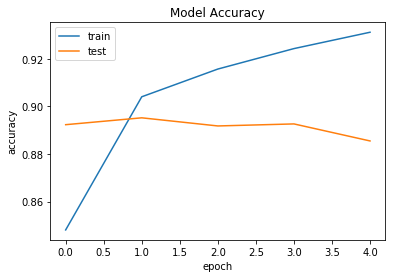

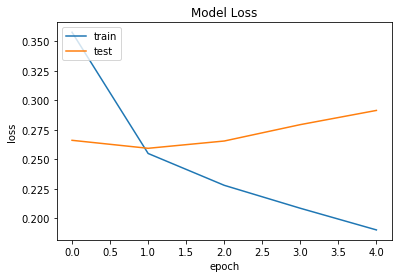

In [85]:
import matplotlib.pyplot as plt
#print(metrics.accuracy_score(Y_test, Y_predicted))

score = model_Wiki_L.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_wiki_L.history.keys())
# summarize history for accuracy
plt.plot(history_wiki_L.history['acc'])
plt.plot(history_wiki_L.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_wiki_L.history['loss'])
plt.plot(history_wiki_L.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
Y_pred = model_Wiki_L.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.601, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

9359/9359 [==============================] - 44s 5ms/step
F1 score at threshold 0.1 is 0.7983870967741934
F1 score at threshold 0.12 is 0.8061237956975057
F1 score at threshold 0.14 is 0.8140125685252039
F1 score at threshold 0.16 is 0.8192510477220495
F1 score at threshold 0.18 is 0.8238023747782176
F1 score at threshold 0.2 is 0.8266483516483516
F1 score at threshold 0.22 is 0.8289309915640989
F1 score at threshold 0.24 is 0.8325905292479109
F1 score at threshold 0.26 is 0.8337538547799271
F1 score at threshold 0.28 is 0.8354251868565788
F1 score at threshold 0.3 is 0.8381519274376416
F1 score at threshold 0.32 is 0.8384341637010676
F1 score at threshold 0.34 is 0.8392908207034601
F1 score at threshold 0.36 is 0.8400803904679873
F1 score at threshold 0.38 is 0.8399366085578448
F1 score at threshold 0.4 is 0.8407938577430103
F1 score at threshold 0.42 is 0.8406513521372492
F1 score at threshold 0.44 is 0.8398015757222059
F1 score at threshold 0.46 is 0.8397773872290568
F1 score at thr

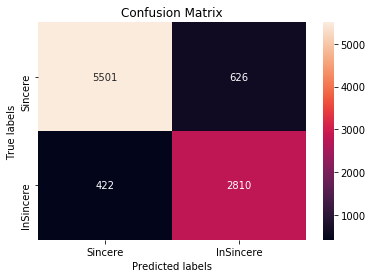

In [87]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.56).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

Running the best Models with a bit of Tuning 

### 1. Bidirectional LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          9000000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total para

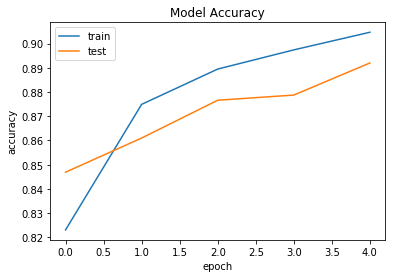

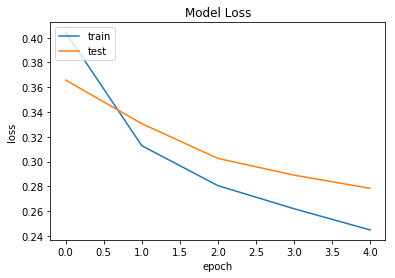

9359/9359 [==============================] - 21s 2ms/step
F1 score at threshold 0.1 is 0.8028852459016393
F1 score at threshold 0.12 is 0.8106445573682802
F1 score at threshold 0.14 is 0.8176885512750949
F1 score at threshold 0.16 is 0.8246289169873556
F1 score at threshold 0.18 is 0.827000695894224
F1 score at threshold 0.2 is 0.8312676056338029
F1 score at threshold 0.22 is 0.8354682607458013
F1 score at threshold 0.24 is 0.8381718884736993
F1 score at threshold 0.26 is 0.8397035314634501
F1 score at threshold 0.28 is 0.8436032863849765
F1 score at threshold 0.3 is 0.8441750443524543
F1 score at threshold 0.32 is 0.8448019064641049
F1 score at threshold 0.34 is 0.8454258675078864
F1 score at threshold 0.36 is 0.8453139217470428
F1 score at threshold 0.38 is 0.845247206490127
F1 score at threshold 0.4 is 0.8443483631871526
F1 score at threshold 0.42 is 0.8437257036230759
F1 score at threshold 0.44 is 0.8440826549780839
F1 score at threshold 0.46 is 0.8426028044745549
F1 score at thres

In [60]:

model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embed_size, input_length=maxlen))
model_lstm.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model_lstm.add(BatchNormalization())
model_lstm.add(GlobalMaxPool1D())
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01, momentum=0.9)
model_lstm.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_lstm.summary()

## Train the LSTM model 
history_lstm = model_lstm.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_lstm.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['acc'])
plt.plot(history_lstm.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Y_pred = model_lstm.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

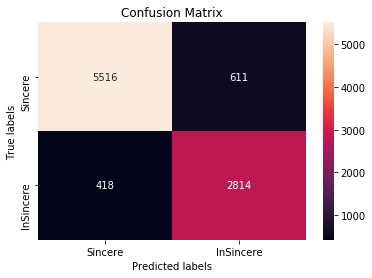

In [61]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.34).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### 2. Wiki text Embedding with Bidirectional GRU 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 300)          9000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 300)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
__________

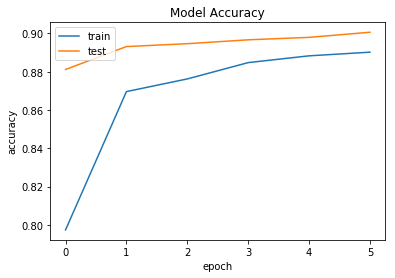

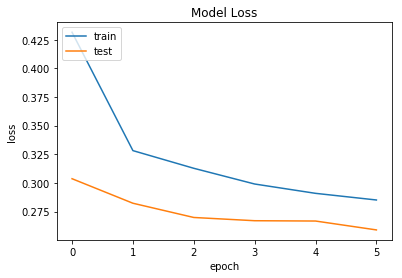

In [64]:

model_Wiki = Sequential()
model_Wiki.add(Embedding(max_features, embed_size, input_length=maxlen, weights=[embedding_matrix]))
model_Wiki.add(SpatialDropout1D(0.2))
model_Wiki.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_Wiki.add(BatchNormalization())
model_Wiki.add(GlobalMaxPool1D())
model_Wiki.add(Dense(16, activation='relu'))
model_Wiki.add(Dropout(0.3))
model_Wiki.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01, momentum=0.9)
model_Wiki.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_Wiki.summary()

## Train the LSTM model 
history_wiki = model_Wiki.fit(X_train, Y_train, batch_size=128, epochs=6, validation_data=(X_test, Y_test))

score = model_Wiki.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_wiki.history.keys())
# summarize history for accuracy
plt.plot(history_wiki.history['acc'])
plt.plot(history_wiki.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_wiki.history['loss'])
plt.plot(history_wiki.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
Y_pred = model_Wiki.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

9359/9359 [==============================] - 22s 2ms/step
F1 score at threshold 0.1 is 0.7922077922077924
F1 score at threshold 0.12 is 0.8035297171035557
F1 score at threshold 0.14 is 0.812689219428722
F1 score at threshold 0.16 is 0.8193574190107985
F1 score at threshold 0.18 is 0.824244060475162
F1 score at threshold 0.2 is 0.8287232592996321
F1 score at threshold 0.22 is 0.833447943886673
F1 score at threshold 0.24 is 0.8374028856825749
F1 score at threshold 0.26 is 0.8413542249580303
F1 score at threshold 0.28 is 0.8441193021947102
F1 score at threshold 0.3 is 0.8477552754567341
F1 score at threshold 0.32 is 0.8500071357214215
F1 score at threshold 0.34 is 0.85163332853648
F1 score at threshold 0.36 is 0.8547429398986242
F1 score at threshold 0.38 is 0.8560583941605839
F1 score at threshold 0.4 is 0.8571008526903853
F1 score at threshold 0.42 is 0.8582840236686391
F1 score at threshold 0.44 is 0.8587183308494785
F1 score at threshold 0.46 is 0.8603569821508924
F1 score at threshol

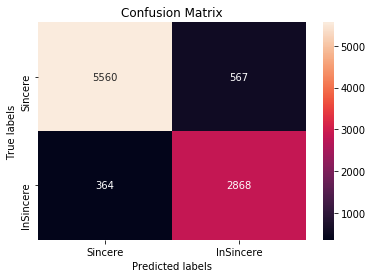

In [66]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.46).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

I have run multiple Deep Learning models like LSTM, GRU, Conv1D, Bidirectional LSTM and used different Embeddings from training my own Embedding layer to using Wiki Fast Text Embedding. Lets do the next part of Tuning various hyperparameters now.

I will select the best Model from here and use it for further tuning. 

### License
MIT License

Copyright (c) 2020 Nikhil Kohli

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.